# Jupyter-based workflows in the wet lab

***

We have been experimenting with using Jupyter notebooks for all of our wet lab work, including designing protocols, running expierments, and analysing results. 

This notebook is intended to illustrate some of the concepts behind our workflows, without getting bogged down in the details of our tooling or applications.

We hope to document and share more of our workflows over time, particularly as our tooling stabalizes.

<div class="alert alert-block alert-warning">
    <b>Warning:</b> we haven't run the protocols in this notebook. While they have been modeled on protocols from reputable sources, we haven't used these or even closely reviewed them. They are intended to as examples only. 
</div>

In [1]:
# First, we setup our environment...

# For units
import pint
ureg = pint.UnitRegistry()
# use this constructor for temperatures: https://pint.readthedocs.io/en/latest/nonmult.html
Q_ = ureg.Quantity

# For figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# note: matplotlib uses pillow behind the scenes, need to have it installed
import pandas as pd

# For timestamps
import datetime
def lab_timestamp():
    ts = datetime.datetime \
        .now(datetime.timezone.utc) \
        .strftime('%H:%M:%S on %A, %B %dth, %Y (%Z)')
    return(ts)

## Example framework for protocols

***

We want to start with a basic framework for protocols. To start simple, we'll just use lists, strings to make a "protocol" type:

- A protocol is a list of steps.
- A step is a list of tasks.
- A task is a string that describes one or more actions.
- The first task (0-task) in a step describes the step. 
- The first step (0-step) in a protocol describes the protocol.
- For the 0-step, all tasks except the 0-task are ignored.

An example "protocol" using literals:

```python
protocol = [
    ['Do the hokey pokey', 'ignored!', 'ignored!'],
    ['First step', 'put your right leg in', 'put your right leg out'],
    ['Second step','put your right leg in', 'shake it all about']
]
```

These conventions are enough to build useful abstractions and tools.
If you commit to this approach,
it makes sense implement this kind of functionality
into types, methods, and modules.

In [2]:
# Some generic reusable steps...

# Ice
def ice_step(mat, time):
    return([
        'Ice',
        f'DO: place *{mat}* on ice.',
        f'WAIT: **{time}**.'
    ])

# Heat
def heat_step(mat, temp, time):
    return([
        'Heat',
        f'DO: heat *{mat}* at **{temp}**.',
        f'WAIT: **{time}**.'
    ])

# Cool
def cool_step(mat, temp):
    return([
        'Cool',
        f'DO: let *{mat}* cool to **{temp}**.'
    ])

# Incubate
def incubate_step(mat, temp, rpm, time):
    return([
        'Incubate',
        f'DO: place *{mat}* in **{temp}** {"incubator" if rpm == 0 else f"shaker at **{rpm}** rpm"}.',
        f'WAIT: **{time}**.'
    ])

# Add
def add_step(qty, mat1, mat2):
    return([
        'Add',
        f'DO: add **{qty}** of *{mat1}* to *{mat2}*.'
    ])

# Autoclave
def autoclave_step(mat, temp, pressure, time):
    return ([
        'Autoclave',
        f'DO: run *{mat}* in autoclave at **{temp}** and **{pressure}**.',
        f'WAIT: **{time}**'
    ])

# Store
def store_step(mat, temp):
    return([
        'Store',
        f'DO: store *{mat}* at **{temp}**.'
    ])

# Our formatter...
def format_protocol(protocol):
    s = [] # list of strings
    i = 0
    for step in protocol:
        j = 0
        for task in step:
            if i == 0:
                s.append(f'### {task}\n')
                break
            elif i != 0 and j == 0:
                s.append(f'{i}. [ ] {task}')
            else:
                s.append(f'    {j}. {task}')
            j = j+1
        i = i+1
    s.append('\nTimestamp: {}\n'.format(lab_timestamp()))
    return('\n'.join(s))

# A helper function...
def roundUpToMultiple(number, multiple):
    n = number + (multiple - 1)
    return(n - (n % multiple))

## Demo 1: protocol for pouring LB + amp plates

***

Here is an example of translating an LB + amp. plate protocol 
into the framework introduced above. 
It's notable that:

- it can be trivially adapted to any number of plates of any size, as those are explicit paramaters of the protocol;
- it selects appropriately sized glassware based on parameters;
- all of the necessary assumptions and calculations are embedded right in the protocol; and 
- pint helps make sure our calculations are correct (it uncovers dimensionality errors).

The output of this is a markdown-formatted string, 
which looks just like a traditional protocol.
You can use that as the basis of individual experiments, 
which can be kept together in one notebook 
or each kept in separate notebooks. 
And since it's just markdown, 
you can take notes from individual experiments directly in the formatted protocol 
or make notes in separate cells.

The underlying protocol "instance" can also be used in other applications,
including transformations of protocols 
and producing other human interfaces, like interactive runners.

In [3]:
# Demo protocol: pouring LB + amp. plates
# Forked from: https://www.addgene.org/protocols/pouring-lb-agar-plates/

# Adjust number of plates to pour
NUM_PLATES = 4
# Adjust based on plate size
PLATE_POUR_VOLUME = 20 * ureg.ml

# Function returns protocol data type
def demo1_protocol(num_plates, plate_pour_volume):
    # Adjust based on lab's stock solution
    amp_stock_concentration = (100 * ureg.mg) / ureg.ml
    # Remainder from upstream addgene protocol
    agar_final_concentration = (12 * ureg.g) / (1 * ureg.l)
    amp_final_concentration = (100 * ureg.ug) / ureg.ml
    autoclave_temp = Q_(121, ureg.degC)
    autoclave_pressure = 20 * ureg.psi
    autoclave_time = 30 * ureg.minute
    cool_temp = Q_(60, ureg.degC)
    solidify_time = 30 * ureg.minute

    store_temp = Q_(4, ureg.degC)

    # Calc. pour volume (how much agar solution we're making)
    actual_pour_volume = num_plates * plate_pour_volume
    # Round "safe" volume by rounding up to nearest 50ml (make sure we're not short when pouring)
    safe_pour_volume = Q_(roundUpToMultiple((actual_pour_volume).m_as(ureg.ml), 50), ureg.ml)
    # Pick smallest liter-incremented flask that's 2x our safe pour volume
    flask_size = Q_(roundUpToMultiple(safe_pour_volume.m_as(ureg.ml) * 2, 1000), ureg.ml).to(ureg.l)
    # Calc. agar mass to add
    agar_mass = (safe_pour_volume * agar_final_concentration).to(ureg.g)
    # Calc. amount of amp. stock solution to add
    amp_stock_volume = safe_pour_volume / (amp_stock_concentration / amp_final_concentration)

    # DRY helper
    swirl_step = ['Swirl', 'DO: swirl *flask* to mix agar solution.']

    # Steps
    p = []
    p.append([f'Protocol: pour {NUM_PLATES} LB + amp. plates'])
    p.append([
        'Setup',
        'DO: prepare *liquid LB medium* (if necessary).',
        f'DO: prepare **{amp_stock_concentration}** *amp. stock solution* (if necessary).',
    ])
    p.append(add_step(safe_pour_volume, 'liquid LB medium', f'{flask_size} flask'))
    p.append(add_step(agar_mass, 'agar', 'flask'))
    p.append(swirl_step)
    p.append(autoclave_step('flask', autoclave_temp, autoclave_pressure, autoclave_time))
    p.append(cool_step('flask', cool_temp))
    p.append(swirl_step)
    p.append([
        'Pour',
        f'DO: pipette or pour **{plate_pour_volume}** from *flask* to each of **{NUM_PLATES}** *plates*.',
        f'NOTE: you may have up to **{safe_pour_volume - actual_pour_volume}** agar solution left over.',
        f'WAIT: {solidify_time} (until solidified and cool).'
    ])
    p.append(store_step('plates', store_temp))
    
    # Return
    return(p)

# Print
print(format_protocol(demo1_protocol(NUM_PLATES, PLATE_POUR_VOLUME)))

### Protocol: pour 4 LB + amp. plates

1. [ ] Setup
    1. DO: prepare *liquid LB medium* (if necessary).
    2. DO: prepare **100.0 milligram / milliliter** *amp. stock solution* (if necessary).
2. [ ] Add
    1. DO: add **100 milliliter** of *liquid LB medium* to *1.0 liter flask*.
3. [ ] Add
    1. DO: add **1.2 gram** of *agar* to *flask*.
4. [ ] Swirl
    1. DO: swirl *flask* to mix agar solution.
5. [ ] Autoclave
    1. DO: run *flask* in autoclave at **121 degree_Celsius** and **20 pound_force_per_square_inch**.
    2. WAIT: **30 minute**
6. [ ] Cool
    1. DO: let *flask* cool to **60 degree_Celsius**.
7. [ ] Swirl
    1. DO: swirl *flask* to mix agar solution.
8. [ ] Pour
    1. DO: pipette or pour **20 milliliter** from *flask* to each of **4** *plates*.
    2. NOTE: you may have up to **20 milliliter** agar solution left over.
    3. WAIT: 30 minute (until solidified and cool).
9. [ ] Store
    1. DO: store *plates* at **4 degree_Celsius**.

Timestamp: 18:28:08 on Tuesday, J

<div class="alert alert-block alert-info">
    <b>Note:</b> this is what the protocol looks like when formatted and rendered (pasted into a markdown cell).
</div>

### Protocol: pour 4 LB + amp. plates

1. [ ] Setup
    1. DO: prepare *liquid LB medium* (if necessary).
    2. DO: prepare **100.0 milligram / milliliter** *amp. stock solution* (if necessary).
2. [ ] Add
    1. DO: add **100 milliliter** of *liquid LB medium* to *1.0 liter flask*.
3. [ ] Add
    1. DO: add **1.2 gram** of *agar* to *flask*.
4. [ ] Swirl
    1. DO: swirl *flask* to mix agar solution.
5. [ ] Autoclave
    1. DO: run *flask* in autoclave at **121 degree_Celsius** and **20 pound_force_per_square_inch**.
    2. WAIT: **30 minute**
6. [ ] Cool
    1. DO: let *flask* cool to **60 degree_Celsius**.
7. [ ] Swirl
    1. DO: swirl *flask* to mix agar solution.
8. [ ] Pour
    1. DO: pipette or pour **20 milliliter** from *flask* to each of **4** *plates*.
    2. NOTE: you may have up to **20 milliliter** agar solution left over.
    3. WAIT: 30 minute (until solidified and cool).
9. [ ] Store
    1. DO: store *plates* at **4 degree_Celsius**.

Timestamp: 18:28:08 on Tuesday, July 07th, 2020 (UTC)

## Demo 2: plasmid transformation

***

This is an example of a plasmid transformation protocol.
It shares many features of the protocol above,
but this one also includes an example of varying the number of steps
based on a parameter.

Specifically,
this protocol gives you more dilution steps
based on the desired number of serial dilutions.
You could similarly add, remove, or reorder protocol steps
based on parameters.
For example, you may want to vary a bacterial expression protocol
based on the strain and construct.

In [4]:
# Demo protocol: plasmid transformation
# Forked from: https://www.neb.com/protocols/0001/01/01/high-efficiency-transformation-protocol-c2566

# Strain and construct are just labels; logic does not depend on them, but could
STRAIN = 'BL21(DE3)'
CONSTRUCT = 'EGFP'
# Adjust desired dilutions; use [1] for no dilutions
DILUTIONS_LIST = [1, 10, 100]
# Adjust based on plate size
DILUTION_VOLUME = 100 * ureg.ul

def demo2_protocol(strain, construct, dilutions_list, dilution_volume):
    # Strain and plasmid quantities
    strain_volume = 50 * ureg.ul
    final_plasmid_mass = 1 * ureg.pg
    plasmid_concentration = (1 * ureg.pg) / (1 * ureg.ul)
    plasmid_volume = final_plasmid_mass / plasmid_concentration
    
    # For transformation steps
    ice1_time = 30 * ureg.minute
    heat1_temp = Q_(42, ureg.degC)
    heat1_time = 10 * ureg.second
    ice2_time = 5 * ureg.minute
    
    # For incubation1 (vector)
    medium = 'SOC medium'
    medium_volume = 950 * ureg.ul
    medium_temp = Q_(20, ureg.degC)
    incubate1_temp = Q_(37, ureg.degC)
    incubate1_rpm = 250
    incubate1_time = 60 * ureg.minutes
    
    # For heating the plates
    heat2_temp = Q_(37, ureg.degC)
    heat2_time = 30 * ureg.minute 
    
    # For dilutions
    num_dilutions = len(dilutions_list)
    
    # For vector storage
    store_temp = Q_(-80, ureg.degC)
    
    # For incubation2 (plates)
    incubate2_temp = Q_(37, ureg.degC)
    incubate2_rpm = 0
    incubate2_time = 'overnight'
    
    # Steps
    p = []
    p.append([
        f'Protocol: transform {construct} contruct into {strain}'
    ])
    p.append([
        'Setup',
        'DO: prepare ice bath',
        f'DO: prepare **{num_dilutions}** *selection plates*.'
    ])
    p.append([
        'Thaw',
        'DO: place *strain tube* in ice bath.',
        'WAIT: until *strain tube* ice crystals disappear'
    ])
    p.append([
        'Combine',
        'DO: mix *strain tube* gently with pipette tip.',
        f'DO: pipette **{strain_volume}** from *strain tube* to *transformation tube*.',
        f'DO: pipette **{plasmid_volume}** of *plasmid DNA* to *transformation tube*.',
        'DO: flick *transformation tube* 4-5 times.'
    ])
    p.append(ice_step('transformation tube', ice1_time))
    p.append(heat_step('transformation tube', heat1_temp, heat1_time))
    p.append(ice_step('transformation tube', ice2_time))
    p.append(add_step(medium_volume, f'{medium} @ ~{medium_temp}', 'transformation tube'))
    p.append(incubate_step('transformation tube', incubate1_temp, incubate1_rpm, incubate1_time))
    p.append(heat_step(f'selection plates', heat2_temp, heat2_time))
    # Here is an example of modifying the number of protocol steps based on parameters.
    # You can similarly add, remove, or reorder protocol steps based on parameters.
    for d in dilutions_list: 
        p.append([
            f'Dilute {d}x',
            f'DO: combine **{dilution_volume/d}** *transformation* and **{dilution_volume*(1-1/d)}** *{medium}* in new *dilution tube*.',
            f'DO: spread ~**{100 * ureg.ul}** *dilution* on new *selection plate*.'
        ])
    p.append(store_step('transformation tube', store_temp))
    p.append(incubate_step('selection plates', incubate2_temp, incubate2_rpm, incubate2_time))
    
    # Return
    return(p)
    
# Print
print(format_protocol(demo2_protocol(STRAIN, CONSTRUCT, DILUTIONS_LIST, DILUTION_VOLUME)))

### Protocol: transform EGFP contruct into BL21(DE3)

1. [ ] Setup
    1. DO: prepare ice bath
    2. DO: prepare **3** *selection plates*.
2. [ ] Thaw
    1. DO: place *strain tube* in ice bath.
    2. WAIT: until *strain tube* ice crystals disappear
3. [ ] Combine
    1. DO: mix *strain tube* gently with pipette tip.
    2. DO: pipette **50 microliter** from *strain tube* to *transformation tube*.
    3. DO: pipette **1.0 microliter** of *plasmid DNA* to *transformation tube*.
    4. DO: flick *transformation tube* 4-5 times.
4. [ ] Ice
    1. DO: place *transformation tube* on ice.
    2. WAIT: **30 minute**.
5. [ ] Heat
    1. DO: heat *transformation tube* at **42 degree_Celsius**.
    2. WAIT: **10 second**.
6. [ ] Ice
    1. DO: place *transformation tube* on ice.
    2. WAIT: **5 minute**.
7. [ ] Add
    1. DO: add **950 microliter** of *SOC medium @ ~20 degree_Celsius* to *transformation tube*.
8. [ ] Incubate
    1. DO: place *transformation tube* in **37 degree_Celsius** sha

<div class="alert alert-block alert-info">
    <b>Note:</b> again, here is the protocol formatted and rendered.
</div>

### Protocol: transform EGFP contruct into BL21(DE3)

1. [ ] Setup
    1. DO: prepare ice bath
    2. DO: prepare **3** *selection plates*.
2. [ ] Thaw
    1. DO: place *strain tube* in ice bath.
    2. WAIT: until *strain tube* ice crystals disappear
3. [ ] Combine
    1. DO: mix *strain tube* gently with pipette tip.
    2. DO: pipette **50 microliter** from *strain tube* to *transformation tube*.
    3. DO: pipette **1.0 microliter** of *plasmid DNA* to *transformation tube*.
    4. DO: flick *transformation tube* 4-5 times.
4. [ ] Ice
    1. DO: place *transformation tube* on ice.
    2. WAIT: **30 minute**.
5. [ ] Heat
    1. DO: heat *transformation tube* at **42 degree_Celsius**.
    2. WAIT: **10 second**.
6. [ ] Ice
    1. DO: place *transformation tube* on ice.
    2. WAIT: **5 minute**.
7. [ ] Add
    1. DO: add **950 microliter** of *SOC medium @ ~20 degree_Celsius* to *transformation tube*.
8. [ ] Incubate
    1. DO: place *transformation tube* in **37 degree_Celsius** shaker at **250** rpm.
    2. WAIT: **60 minute**.
9. [ ] Heat
    1. DO: heat *selection plates* at **37 degree_Celsius**.
    2. WAIT: **30 minute**.
10. [ ] Dilute 1x
    1. DO: combine **100.0 microliter** *transformation* and **0.0 microliter** *SOC medium* in new *dilution tube*.
    2. DO: spread ~**100 microliter** *dilution* on new *selection plate*.
11. [ ] Dilute 10x
    1. DO: combine **10.0 microliter** *transformation* and **90.0 microliter** *SOC medium* in new *dilution tube*.
    2. DO: spread ~**100 microliter** *dilution* on new *selection plate*.
12. [ ] Dilute 100x
    1. DO: combine **1.0 microliter** *transformation* and **99.0 microliter** *SOC medium* in new *dilution tube*.
    2. DO: spread ~**100 microliter** *dilution* on new *selection plate*.
13. [ ] Store
    1. DO: store *transformation tube* at **-80 degree_Celsius**.
14. [ ] Incubate
    1. DO: place *selection plates* in **37 degree_Celsius** incubator.
    2. WAIT: **overnight**.

Timestamp: 18:29:24 on Tuesday, July 07th, 2020 (UTC)


## Demo 3: results from plasmid transformation

***

We've gone though a couple of examples of using Jupyter notebooks to develop and parameterize protocols. We also use them as lab notebooks and for analyses. We wanted to drop in one example of how you can include non-numeric, non-computational results in a notebook, along side protocols and notes from the lab.

In [5]:
# Dilutions from a hypothetical experiment run on April 1, 2020...
# Using Jupyter, you can systematize how you store and retrieve parameters and results
# from individual experiments making analysis easier and more reproducable
X20200401A_DILUTIONS_LIST = [1, 10, 100]

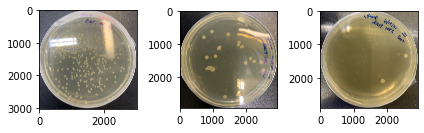

In [6]:
# Plot images of culture dishes
imgs = [mpimg.imread(f'./data/X20200401A/{str(i)}x_transform.jpg') for i in X20200401A_DILUTIONS_LIST]
fig, ax =plt.subplots(nrows=1, ncols=3)
for i, axi in enumerate(ax):
    axi.imshow(imgs[i])
plt.tight_layout()
plt.show()

In [7]:
# Present numerical results in tables
pd.DataFrame({
    'Dilution' : X20200401A_DILUTIONS_LIST,
    'Colonies' : [252, 21, 2]
})

Dilution  Colonies
0         1       252
1        10        21
2       100         2